In [41]:
# # QC tensorflow installation
# import tensorflow as tf
# import keras
# print(tf.__version__)
# print(keras.__version__)

# Command Space
# %

## Import Libraries

In [42]:
# Import required libraries
import numpy as np
import tensorflow as tf
# from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import os
import pandas as pd


## Load CIFAR-10 Dataset

We load the CIFAR-10 dataset, perform some preprocessing like normalization and one hot encoding of labels/targets.

In [43]:
import numpy as np
import os

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10_train_test(data_dir):
    """
    Function to load CIFAR-10 training and test data.

    Args:
    data_dir (str): Path to the directory containing CIFAR-10 data files.

    Returns:
    X_train (ndarray): Training data features
    Y_train (ndarray): Training data labels
    X_test (ndarray): Test data features
    Y_test (ndarray): Test data labels
    """
    X_train = []
    Y_train = []

    for i in range(1, 6):  # Load training data from 5 batches
        batch_file = os.path.join(data_dir, 'data_batch_' + str(i))
        batch_data = unpickle(batch_file)
        X_train.append(batch_data[b'data'])
        Y_train += batch_data[b'labels']

    X_train = np.concatenate(X_train, axis=0)
    Y_train = np.array(Y_train)

    # Load test data from the test batch
    test_batch_file = os.path.join(data_dir, 'test_batch')
    test_batch_data = unpickle(test_batch_file)

    X_test = test_batch_data[b'data']
    Y_test = np.array(test_batch_data[b'labels'])

    # Reshaping and re-arranging color channels to represent RGB image required as input to CNN
    # Reshape to (50000, 3, 32, 32) and move the color channel axis to the last dimension
    X_train = X_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    X_test = X_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    return X_train, Y_train, X_test, Y_test


Create validation data from train set (20% split):

In [44]:
from sklearn.model_selection import train_test_split

# Directory containing CIFAR-10 data files
# data_dir = 'dataset\cifar-10-python\cifar-10-batches-py'
data_dir = 'dataset/cifar-10-python/cifar-10-batches-py'

# Load CIFAR-10 training and test data
X_train, Y_train, X_test, Y_test = load_cifar10_train_test(data_dir)

# Split the training data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [45]:
# Ensuring we parsed the data correctly:
print('Train Set:')
print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)
print('Validation Set:')
print('X_val shape: ', X_val.shape)
print('Y_val shape: ', Y_val.shape)
print('Test Set:')
print('X_test shape: ', X_test.shape)
print('Y_test shape: ', Y_test.shape)

Train Set:
X_train shape:  (45000, 32, 32, 3)
Y_train shape:  (45000,)
Validation Set:
X_val shape:  (5000, 32, 32, 3)
Y_val shape:  (5000,)
Test Set:
X_test shape:  (10000, 32, 32, 3)
Y_test shape:  (10000,)


### Setup ImageDataGenerator

In order to make the most of fewer training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

NOTE: ImageDataGenerator will NOT add new images to your data set in a sense that it will not make your epochs bigger. Instead, in each epoch it will provide slightly altered images (depending on your configuration). It will always generate new images, no matter how many epochs you have.

So in each epoch model will train on different images, but not too different. This should prevent overfitting and in some way simulates online learning.

In [46]:
from keras.preprocessing.image import ImageDataGenerator

# Construct the training image generator for data augmentation
datagen = ImageDataGenerator(
        rotation_range=10, # rotation
        width_shift_range=0.1, # horizontal shift
        height_shift_range=0.1, # vertical shift
        # zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        # brightness_range=[0.2,1.0] # brightness
)

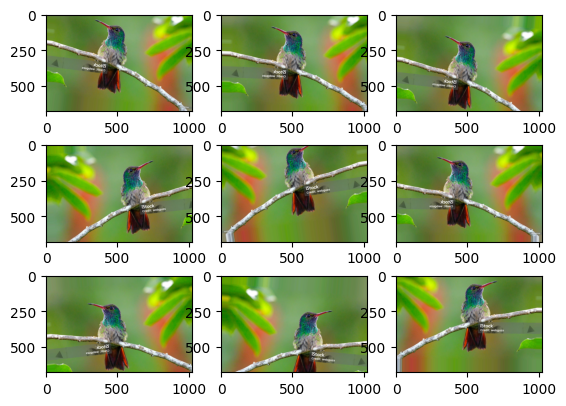

In [47]:
# Example of image augmentation on sample image:
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from matplotlib import pyplot


img = load_img('bird.jpeg') # load image
data = img_to_array(img) # convert to numpy array
samples = expand_dims(data, 0) # expand dimension to one sample

# Prepare iterator
it = datagen.flow(samples, batch_size=1)

# Generate samples and plot
for i in range(9):
    pyplot.subplot(330 + 1 + i) # define subplot
    batch = it.next() # generate batch of images
    image = batch[0].astype('uint8') # convert to unsigned integers
    pyplot.imshow(image)

# show the figure
pyplot.show()
# Adapted code for displaying augmentation results: https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

### Pre-process dataset

In [48]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# One-hot encode the labels
Y_train = to_categorical(Y_train, 10)
Y_test = to_categorical(Y_test, 10)
Y_val = to_categorical(Y_val, 10)

## Build and Train Model

The following cell has the supporting utility functions to plot accuracy curves, loss curves from training process and final evaluation of the classification model. I have provided inline comments explaining purpose of each function and code used. 

In [49]:
# Import required libraries
import matplotlib.pyplot as plt

def plot_accuracy(history, title):
    """
    Function to plot accuracy curves for both training and validation sets.

    Args:
    history (History): Keras History object containing training history
    title (str): Title of the plot
    name (String): A String for the name of the output file. Cannot contain spaces
    """
    ax = plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    save_plot(plt, title)
    plt.show()

def plot_loss(history, title, name="undefined"):
    """
    Function to plot loss curves for both training and validation sets.

    Args:
    history (History): Keras History object containing training history
    title (str): Title of the plot
    name (String): A String for the name of the output file. Cannot contain spaces
    """
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    save_plot(plt, title)
    plt.show()

def evaluate_model(model, X_test, Y_test):
    """
    Function to evaluate the performance of a trained model on the test dataset.

    Args:
    model (Sequential): Trained Keras model
    X_test (ndarray): Test dataset features
    Y_test (ndarray): One-hot encoded labels for test dataset
    """
    _, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print("Test Accuracy: %.2f%%" % (accuracy * 100))
    
def save_plot(plt, name):
    """
    Function to save a plot. Call function before plt.show().

    Args:
    plt (matplotlib.pyplot object): Plot to save
    name (String): A String for the name of the output file. Cannot contain spaces
    """
    filepath = "Graphs/" + name
    # if os.path.isfile(filepath):
    #     filepath += "_second"
    #     print("Same filename. Please alter the params_string. You will not get another warning before losing figures!!")
    plt.savefig(filepath)


In [50]:
from tensorflow.keras.layers import Input, Add, Activation, AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

def resnet_block(inputs, filters, kernel_size, strides, skip_kernel_size=(1, 1), activation='relu', num_layers=2, dropout=0):
    """
    Function to create a single ResNet block.

    Args:
    inputs (tensor): Input tensor
    filters (int): Number of filters in the convolutional layers
    kernel_size (int or tuple): Size of the convolutional kernel
    strides (int or tuple): Strides of the convolutional kernel
    skip_kernel_size (int or tuple): Size of the skip connection kernel
    activation (str): Activation function to use
    num_layers (int): Number of convolutional layers per block
    dropout (int): A value from 0-1 for dropout regularization

    Returns:
    tensor: Output tensor of the ResNet block
    """
    shortcut = inputs

    # Create initial convolutional layer and batch normalization without an activation layer afterwards
    x = Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')(inputs)
    x = Dropout(dropout)(x)
    x = BatchNormalization()(x)
    
    # Create (num_layers - 1) convolutional layers with activation layer beforehand
    # Final layer does not have an activation layer as desired
    if num_layers > 1:
        for i in range(num_layers - 1):
            x = Activation(activation)(x)
            x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
            x = Dropout(dropout)(x)
            x = BatchNormalization()(x)
    

    # Shortcut connection
    if strides != 1 or inputs.shape[-1] != filters:
        # change (1,1) to variable (the kernel size in the ith skip connection)
        shortcut = Conv2D(filters, skip_kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')(inputs)
        shortcut = Dropout(dropout)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation(activation)(x)
    return x

def build_resnet(init_filters=64, res_layers=[2, 2], conv_kernel_size=(3,3), skip_kernel_size=(1, 1), conv_per_layer=2, pool_size=(8, 8), optimizer='adam', dropout=0):
    """
    Function to build a ResNet model using multiple Resnet style blocks.
    
    Args:
    init_filters (int): Number of filters in the first layer
    r_layers (list of ints): Network architecture as a list where the length of the list is the number of Residual Layers and the value of each element is the number of blocks in that layer
    conv_kernel_size (int or tuple): Size of the convolutional kernel
    skip_kernel_size (int or tuple): Size of the skip connection kernel
    conv_per_layer (int): Number of convolutional layers per residual block
    pool_size (int or tuple): Size of the pooling layer
    optimizer (String): Acceptable keras optimizers such as SGD or adam
    dropout (int): A value from 0-1 for dropout regularization

    Returns:
    model (Model): Compiled ResNet model
    """
    inputs = Input(shape=(32, 32, 3))
    num_filters = init_filters
    num_blocks_list = res_layers  # ResNet Style architecture for CIFAR-10

    x = Conv2D(num_filters, conv_kernel_size, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Add ResNet blocks
    for i, num_blocks in enumerate(num_blocks_list):
        for j in range(num_blocks):
            strides = 1
            if i > 0 and j == 0:  # Downsample at the beginning of each stage
                strides = 2
            x = resnet_block(x, num_filters, conv_kernel_size, strides, skip_kernel_size=skip_kernel_size, num_layers=conv_per_layer)

        num_filters *= 2  # Double the number of filters after each stage

    x = AveragePooling2D(pool_size=pool_size)(x) # pool size could be hyperparameter
    x = Flatten()(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    # optimizer can be a parameter: vanilla sgd, sgd with fixed learning rate, or adam 
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [51]:
# Build ResNet model
resnet_model = build_resnet(init_filters=64, res_layers=[4, 3, 3], conv_kernel_size=(3,3), skip_kernel_size=(3, 3), conv_per_layer=2, pool_size=(8, 8), optimizer='adam', dropout=0.1)
resnet_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_226 (Conv2D)            (None, 32, 32, 64)   1792        ['input_11[0][0]']               
                                                                                                  
 batch_normalization_226 (Batch  (None, 32, 32, 64)  256         ['conv2d_226[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_206 (Activation)    (None, 32, 32, 64)   0           ['batch_normalization_226[

### Enabling Keras Callbacks

Callback to save the Keras model weights after every epoch that obtains the best validation accuracy thus far.

In [52]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Filepath for storing model weights
checkpoint_filepath = 'ckpt/Single Model Output/model_2'

# Defining callback
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

## Model Training

In [53]:
# Augmenting on the fly with datagen.flow()
batch_size=128
epochs=200

# Directly use .flow() to load our dataset in batches for training
resnet_history = resnet_model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size), 
                                  epochs = epochs, # set number of epochs
                                  steps_per_epoch = X_train.shape[0]//batch_size, # number of images composing one epoch
                                  validation_data = (X_val, Y_val), # data for validation
                                  callbacks=[model_checkpoint_callback], # model checkpoint
                                  verbose=1)

Epoch 1/200
351/351 [==============================] - ETA: 0s - loss: 1.3739 - accuracy: 0.5065

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


351/351 [==============================] - 30s 79ms/step - loss: 1.3739 - accuracy: 0.5065 - val_loss: 1.5979 - val_accuracy: 0.4990
Epoch 2/200
351/351 [==============================] - ETA: 0s - loss: 0.9007 - accuracy: 0.6808

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


351/351 [==============================] - 28s 78ms/step - loss: 0.9007 - accuracy: 0.6808 - val_loss: 1.6564 - val_accuracy: 0.5458
Epoch 3/200
351/351 [==============================] - ETA: 0s - loss: 0.7145 - accuracy: 0.7515

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


351/351 [==============================] - 28s 78ms/step - loss: 0.7145 - accuracy: 0.7515 - val_loss: 0.9371 - val_accuracy: 0.6688
Epoch 4/200
351/351 [==============================] - ETA: 0s - loss: 0.6076 - accuracy: 0.7888

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


351/351 [==============================] - 28s 79ms/step - loss: 0.6076 - accuracy: 0.7888 - val_loss: 0.7809 - val_accuracy: 0.7488
Epoch 5/200
351/351 [==============================] - 21s 58ms/step - loss: 0.5356 - accuracy: 0.8145 - val_loss: 0.9608 - val_accuracy: 0.7408
Epoch 6/200
351/351 [==============================] - ETA: 0s - loss: 0.4822 - accuracy: 0.8335

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


351/351 [==============================] - 27s 76ms/step - loss: 0.4822 - accuracy: 0.8335 - val_loss: 0.6965 - val_accuracy: 0.7772
Epoch 7/200
351/351 [==============================] - ETA: 0s - loss: 0.4420 - accuracy: 0.8471

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


351/351 [==============================] - 28s 78ms/step - loss: 0.4420 - accuracy: 0.8471 - val_loss: 0.7058 - val_accuracy: 0.7814
Epoch 8/200
351/351 [==============================] - ETA: 0s - loss: 0.4023 - accuracy: 0.8621

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


351/351 [==============================] - 28s 79ms/step - loss: 0.4023 - accuracy: 0.8621 - val_loss: 0.6895 - val_accuracy: 0.7824
Epoch 9/200
351/351 [==============================] - 21s 58ms/step - loss: 0.3686 - accuracy: 0.8727 - val_loss: 0.7450 - val_accuracy: 0.7738
Epoch 10/200
351/351 [==============================] - ETA: 0s - loss: 0.3467 - accuracy: 0.8791

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


351/351 [==============================] - 27s 77ms/step - loss: 0.3467 - accuracy: 0.8791 - val_loss: 0.4680 - val_accuracy: 0.8454
Epoch 11/200
351/351 [==============================] - ETA: 0s - loss: 0.3201 - accuracy: 0.8894

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


351/351 [==============================] - 28s 79ms/step - loss: 0.3201 - accuracy: 0.8894 - val_loss: 0.4188 - val_accuracy: 0.8566
Epoch 12/200
351/351 [==============================] - 21s 59ms/step - loss: 0.3036 - accuracy: 0.8931 - val_loss: 0.5592 - val_accuracy: 0.8112
Epoch 13/200
351/351 [==============================] - 20s 58ms/step - loss: 0.2826 - accuracy: 0.9010 - val_loss: 0.9036 - val_accuracy: 0.7610
Epoch 14/200
351/351 [==============================] - 20s 57ms/step - loss: 0.2639 - accuracy: 0.9079 - val_loss: 0.4482 - val_accuracy: 0.8522
Epoch 15/200
351/351 [==============================] - 20s 57ms/step - loss: 0.2477 - accuracy: 0.9131 - val_loss: 0.5297 - val_accuracy: 0.8448
Epoch 16/200
351/351 [==============================] - 20s 57ms/step - loss: 0.2369 - accuracy: 0.9191 - val_loss: 0.5552 - val_accuracy: 0.8330
Epoch 17/200
351/351 [==============================] - ETA: 0s - loss: 0.2198 - accuracy: 0.9237

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


351/351 [==============================] - 27s 76ms/step - loss: 0.2198 - accuracy: 0.9237 - val_loss: 0.4694 - val_accuracy: 0.8622
Epoch 18/200
351/351 [==============================] - 20s 56ms/step - loss: 0.2060 - accuracy: 0.9278 - val_loss: 0.7520 - val_accuracy: 0.8126
Epoch 19/200
351/351 [==============================] - 20s 57ms/step - loss: 0.1918 - accuracy: 0.9322 - val_loss: 0.6889 - val_accuracy: 0.8268
Epoch 20/200
351/351 [==============================] - ETA: 0s - loss: 0.1820 - accuracy: 0.9353

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


351/351 [==============================] - 27s 77ms/step - loss: 0.1820 - accuracy: 0.9353 - val_loss: 0.4340 - val_accuracy: 0.8770
Epoch 21/200
351/351 [==============================] - 21s 60ms/step - loss: 0.1716 - accuracy: 0.9402 - val_loss: 0.4460 - val_accuracy: 0.8684
Epoch 22/200
351/351 [==============================] - ETA: 0s - loss: 0.1596 - accuracy: 0.9429

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


351/351 [==============================] - 27s 77ms/step - loss: 0.1596 - accuracy: 0.9429 - val_loss: 0.3585 - val_accuracy: 0.8896
Epoch 23/200
351/351 [==============================] - 20s 57ms/step - loss: 0.1608 - accuracy: 0.9425 - val_loss: 0.5126 - val_accuracy: 0.8436
Epoch 24/200
351/351 [==============================] - 20s 57ms/step - loss: 0.1457 - accuracy: 0.9483 - val_loss: 0.4711 - val_accuracy: 0.8740
Epoch 25/200
351/351 [==============================] - 20s 57ms/step - loss: 0.1381 - accuracy: 0.9510 - val_loss: 0.5922 - val_accuracy: 0.8516
Epoch 26/200
351/351 [==============================] - ETA: 0s - loss: 0.1369 - accuracy: 0.9529

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


351/351 [==============================] - 27s 77ms/step - loss: 0.1369 - accuracy: 0.9529 - val_loss: 0.3477 - val_accuracy: 0.8978
Epoch 27/200
351/351 [==============================] - 20s 57ms/step - loss: 0.1199 - accuracy: 0.9583 - val_loss: 0.4593 - val_accuracy: 0.8790
Epoch 28/200
351/351 [==============================] - 20s 57ms/step - loss: 0.1169 - accuracy: 0.9587 - val_loss: 0.4461 - val_accuracy: 0.8762
Epoch 29/200
351/351 [==============================] - 20s 57ms/step - loss: 0.1109 - accuracy: 0.9611 - val_loss: 0.4150 - val_accuracy: 0.8910
Epoch 30/200
351/351 [==============================] - 20s 56ms/step - loss: 0.1113 - accuracy: 0.9600 - val_loss: 0.4420 - val_accuracy: 0.8860
Epoch 31/200
351/351 [==============================] - 20s 56ms/step - loss: 0.1055 - accuracy: 0.9634 - val_loss: 0.4350 - val_accuracy: 0.8828
Epoch 32/200
351/351 [==============================] - 20s 56ms/step - loss: 0.0972 - accuracy: 0.9657 - val_loss: 0.3764 - val_accuracy

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


351/351 [==============================] - 27s 76ms/step - loss: 0.0837 - accuracy: 0.9698 - val_loss: 0.4115 - val_accuracy: 0.8994
Epoch 36/200
351/351 [==============================] - 20s 56ms/step - loss: 0.0809 - accuracy: 0.9712 - val_loss: 0.4250 - val_accuracy: 0.8926
Epoch 37/200
351/351 [==============================] - 20s 56ms/step - loss: 0.0798 - accuracy: 0.9718 - val_loss: 0.4695 - val_accuracy: 0.8786
Epoch 38/200
351/351 [==============================] - 20s 56ms/step - loss: 0.0777 - accuracy: 0.9729 - val_loss: 0.4451 - val_accuracy: 0.8946
Epoch 39/200
351/351 [==============================] - 20s 56ms/step - loss: 0.0710 - accuracy: 0.9746 - val_loss: 0.5372 - val_accuracy: 0.8832
Epoch 40/200
351/351 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9739

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


351/351 [==============================] - 27s 77ms/step - loss: 0.0723 - accuracy: 0.9739 - val_loss: 0.3647 - val_accuracy: 0.9074
Epoch 41/200
351/351 [==============================] - 20s 56ms/step - loss: 0.0686 - accuracy: 0.9763 - val_loss: 0.4724 - val_accuracy: 0.8884
Epoch 42/200
351/351 [==============================] - 20s 56ms/step - loss: 0.0691 - accuracy: 0.9760 - val_loss: 0.4368 - val_accuracy: 0.8864
Epoch 43/200
351/351 [==============================] - 20s 56ms/step - loss: 0.0623 - accuracy: 0.9783 - val_loss: 0.4075 - val_accuracy: 0.9014
Epoch 44/200
351/351 [==============================] - 20s 56ms/step - loss: 0.0645 - accuracy: 0.9767 - val_loss: 0.4221 - val_accuracy: 0.9014
Epoch 45/200
351/351 [==============================] - 20s 56ms/step - loss: 0.0641 - accuracy: 0.9774 - val_loss: 0.4960 - val_accuracy: 0.8874
Epoch 46/200
351/351 [==============================] - 20s 57ms/step - loss: 0.0592 - accuracy: 0.9791 - val_loss: 0.4332 - val_accuracy

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


351/351 [==============================] - 27s 76ms/step - loss: 0.0473 - accuracy: 0.9834 - val_loss: 0.3766 - val_accuracy: 0.9116
Epoch 53/200
351/351 [==============================] - 20s 56ms/step - loss: 0.0545 - accuracy: 0.9811 - val_loss: 0.3722 - val_accuracy: 0.9102
Epoch 54/200
351/351 [==============================] - 20s 56ms/step - loss: 0.0491 - accuracy: 0.9840 - val_loss: 0.4239 - val_accuracy: 0.9054
Epoch 55/200
351/351 [==============================] - 20s 56ms/step - loss: 0.0448 - accuracy: 0.9844 - val_loss: 0.3686 - val_accuracy: 0.9112
Epoch 56/200
351/351 [==============================] - 20s 56ms/step - loss: 0.0412 - accuracy: 0.9856 - val_loss: 0.3888 - val_accuracy: 0.9076
Epoch 57/200
351/351 [==============================] - 20s 56ms/step - loss: 0.0469 - accuracy: 0.9840 - val_loss: 0.6158 - val_accuracy: 0.8724
Epoch 58/200
351/351 [==============================] - 20s 56ms/step - loss: 0.0466 - accuracy: 0.9836 - val_loss: 0.4224 - val_accuracy

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


351/351 [==============================] - 26s 74ms/step - loss: 0.0382 - accuracy: 0.9873 - val_loss: 0.3695 - val_accuracy: 0.9166
Epoch 71/200
351/351 [==============================] - 19s 54ms/step - loss: 0.0324 - accuracy: 0.9886 - val_loss: 0.4891 - val_accuracy: 0.8988
Epoch 72/200
351/351 [==============================] - 19s 54ms/step - loss: 0.0319 - accuracy: 0.9891 - val_loss: 0.6101 - val_accuracy: 0.8784
Epoch 73/200
351/351 [==============================] - 19s 54ms/step - loss: 0.0341 - accuracy: 0.9877 - val_loss: 0.4850 - val_accuracy: 0.9034
Epoch 74/200
351/351 [==============================] - 19s 54ms/step - loss: 0.0298 - accuracy: 0.9893 - val_loss: 0.4482 - val_accuracy: 0.9012
Epoch 75/200
350/351 [============================>.] - ETA: 0s - loss: 0.0300 - accuracy: 0.9900

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


351/351 [==============================] - 26s 74ms/step - loss: 0.0300 - accuracy: 0.9900 - val_loss: 0.3671 - val_accuracy: 0.9274
Epoch 76/200
351/351 [==============================] - 19s 54ms/step - loss: 0.0297 - accuracy: 0.9899 - val_loss: 0.4620 - val_accuracy: 0.9080
Epoch 77/200
351/351 [==============================] - 19s 54ms/step - loss: 0.0300 - accuracy: 0.9895 - val_loss: 0.4469 - val_accuracy: 0.9080
Epoch 78/200
351/351 [==============================] - 19s 54ms/step - loss: 0.0373 - accuracy: 0.9871 - val_loss: 0.5930 - val_accuracy: 0.8832
Epoch 79/200
351/351 [==============================] - 21s 59ms/step - loss: 0.0273 - accuracy: 0.9906 - val_loss: 0.3991 - val_accuracy: 0.9150
Epoch 80/200
351/351 [==============================] - 21s 59ms/step - loss: 0.0299 - accuracy: 0.9899 - val_loss: 0.4574 - val_accuracy: 0.9076
Epoch 81/200
351/351 [==============================] - 20s 58ms/step - loss: 0.0280 - accuracy: 0.9904 - val_loss: 0.3852 - val_accuracy

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


351/351 [==============================] - 27s 77ms/step - loss: 0.0149 - accuracy: 0.9952 - val_loss: 0.3912 - val_accuracy: 0.9286
Epoch 149/200
351/351 [==============================] - 20s 57ms/step - loss: 0.0164 - accuracy: 0.9940 - val_loss: 0.4363 - val_accuracy: 0.9196
Epoch 150/200
351/351 [==============================] - 20s 57ms/step - loss: 0.0126 - accuracy: 0.9957 - val_loss: 0.5482 - val_accuracy: 0.9064
Epoch 151/200
351/351 [==============================] - 20s 57ms/step - loss: 0.0132 - accuracy: 0.9957 - val_loss: 0.4045 - val_accuracy: 0.9258
Epoch 152/200
351/351 [==============================] - 20s 57ms/step - loss: 0.0134 - accuracy: 0.9953 - val_loss: 0.4893 - val_accuracy: 0.9190
Epoch 153/200
351/351 [==============================] - 20s 57ms/step - loss: 0.0126 - accuracy: 0.9955 - val_loss: 0.4346 - val_accuracy: 0.9236
Epoch 154/200
351/351 [==============================] - 20s 57ms/step - loss: 0.0136 - accuracy: 0.9947 - val_loss: 0.5153 - val_ac

INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


INFO:tensorflow:Assets written to: ckpt/Single Model Output\model_2\assets


351/351 [==============================] - 28s 81ms/step - loss: 0.0119 - accuracy: 0.9957 - val_loss: 0.3614 - val_accuracy: 0.9374
Epoch 176/200
351/351 [==============================] - 21s 59ms/step - loss: 0.0107 - accuracy: 0.9964 - val_loss: 0.3974 - val_accuracy: 0.9226
Epoch 177/200
351/351 [==============================] - 20s 57ms/step - loss: 0.0118 - accuracy: 0.9960 - val_loss: 0.3998 - val_accuracy: 0.9266
Epoch 178/200
351/351 [==============================] - 20s 57ms/step - loss: 0.0107 - accuracy: 0.9962 - val_loss: 0.4013 - val_accuracy: 0.9324
Epoch 179/200
351/351 [==============================] - 20s 57ms/step - loss: 0.0131 - accuracy: 0.9957 - val_loss: 0.4963 - val_accuracy: 0.9136
Epoch 180/200
351/351 [==============================] - 20s 57ms/step - loss: 0.0122 - accuracy: 0.9956 - val_loss: 0.5450 - val_accuracy: 0.9142
Epoch 181/200
351/351 [==============================] - 20s 57ms/step - loss: 0.0125 - accuracy: 0.9955 - val_loss: 0.5221 - val_ac

In [54]:
# resnet_history = resnet_model.fit(X_train, Y_train, batch_size=64, epochs=10, verbose=1, validation_data=(X_val, Y_val))


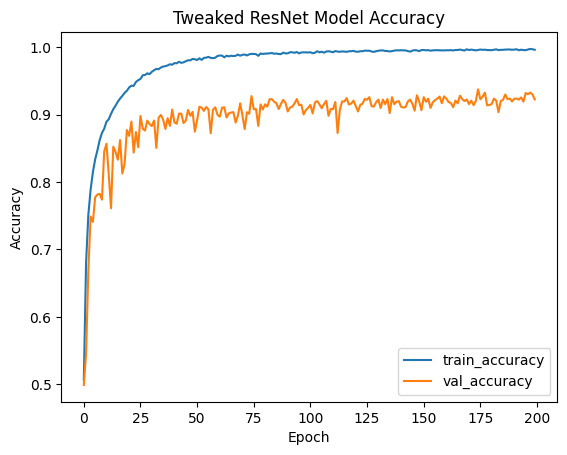

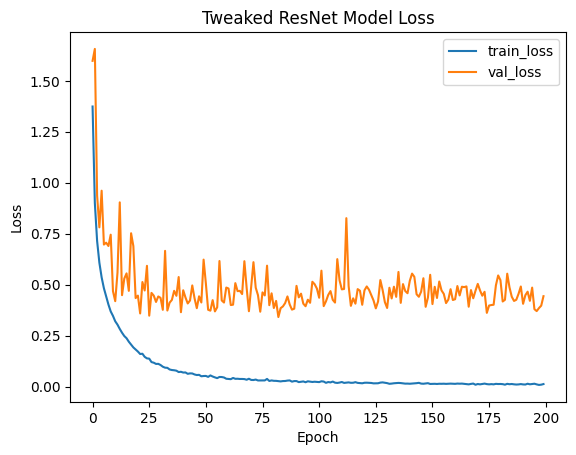

In [55]:
# Plot accuracy and loss
plot_accuracy(resnet_history, 'Tweaked ResNet Model Accuracy')
plot_loss(resnet_history, 'Tweaked ResNet Model Loss')


In [56]:
# Load model with max validation accuracy (our best model as saved on disk)
# Filepath for loading model checkpoint (if not above)
# checkpoint_filepath = 'ckpt/model_checkpoint_testing'

# The model weights (that are considered the best) can be loaded as -
test_model = tf.keras.models.load_model(checkpoint_filepath)

In [57]:
# Evaluate test set using best model 
print('ResNet Model:')
evaluate_model(test_model, X_test, Y_test)

ResNet Model:
Test Accuracy: 92.79%


## Run Inference on Kaggle test set

In [58]:
def save_predictions_to_csv(test_model, test_data_file, output_file):
    """
    Function to make predictions on the Kaggle test dataset and save the results to a CSV file.

    Args:
    test_model: Trained model for making predictions
    test_data_file (str): Path to the test dataset file
    output_file (str): Path to the output CSV file to save the predictions
    """
    # Load the test dataset
    test_data = unpickle(test_data_file)
    X_test_kaggle = test_data[b'data']
    image_ids = test_data[b'ids']

    # Reshape the test data
    X_test_kaggle = X_test_kaggle.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    X_test_kaggle = X_test_kaggle / 255.0  # Normalize pixel values

    print('Load test data from Kaggle:')
    print('X_test_kaggle shape: ', X_test_kaggle.shape)
    print()

    # Make predictions using the trained model
    print('Making predictions...')
    predictions = test_model.predict(X_test_kaggle)

    # Get the predicted labels
    predicted_labels = np.argmax(predictions, axis=1)

    # Create a DataFrame with ID and Labels columns
    results_df = pd.DataFrame({'ID': image_ids, 'Labels': predicted_labels})

    # Save the DataFrame to a CSV file
    results_df.to_csv(output_file, index=False)
    
    # Print Percent Occurrence of Each Label
    freq_arr = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    for label in predicted_labels:
        freq_arr[label] += 1
    freq_arr = freq_arr / 10000
    print("Frequency Array:", "\n",freq_arr)
    

In [59]:
# Example function call to save predictions as a CSV
save_predictions_to_csv(test_model, 'dataset/cifar_test_nolabels.pkl', 'outputs/predictions.csv')


Load test data from Kaggle:
X_test_kaggle shape:  (10000, 32, 32, 3)

Making predictions...
313/313 [==============================] - 2s 6ms/step
Frequency Array: 
 [0.081  0.0947 0.1005 0.1222 0.0862 0.109  0.0837 0.0997 0.0989 0.1241]
